# Flamedisx discrimination and sensitivity study

## 1. Setup

### 1.1 Load libraries

In [1]:
!wget -nc https://raw.githubusercontent.com/FlamTeam/flamedisx-notebooks/master/_if_on_colab_setup_flamedisx.ipynb
BRANCH="master"  # git branch to use (only for Colab)
%run _if_on_colab_setup_flamedisx.ipynb

File ‘_if_on_colab_setup_flamedisx.ipynb’ already there; not retrieving.

Flamedisx is installed :-)


In [2]:
import gzip
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from multihist import Hist1d, Histdd
import numpy as np
import pandas as pd
from scipy import stats
from scipy.constants import golden_ratio
import tensorflow as tf
from tqdm.notebook import tqdm

import flamedisx as fd

have_gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"Running tensorflow {tf.__version__}, GPU {'active' if have_gpu else 'NOT ACTIVE!'}")

Running tensorflow 2.1.0, GPU NOT ACTIVE!


## Setup sources

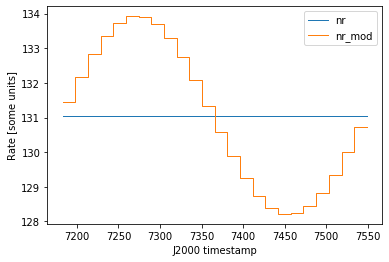

In [3]:
WIMP_MASS = 200

# We want to project to a 1.5 m TPC with 500 us lifetime
# but everything else uses the XENON1T dimensions (~97.8 cm length).
# 500 us * (97.8/150) = 326 us
elife=326e3

# Load energy spectrum for neutron background, use up to 50 keV

radiogenics = pd.read_csv("radiogenic_spectrum.csv", names=['energy', 'rate'])
radiogenics = radiogenics[radiogenics['energy'] < 50]

# Load example spatial hist for neutron background
with open('example_nr_spatial_hist.pkl', mode='rb') as f:
    spatial_data = pickle.load(f)


class MySource:
    fv_radius = spatial_data['fv_radius']
    fv_high = spatial_data['fv_high']
    fv_low = spatial_data['fv_low']
    
    @staticmethod
    def electron_detection_eff(drift_time, *, elife=elife, extraction_eff=0.96):
        return extraction_eff * tf.exp(-drift_time / elife)

    
class WIMPSource(MySource, fd.x1t_sr0.SR0WIMPSource):
    """WIMP dark matter source with modulation artificially removed"""

    mw = WIMP_MASS  # GeV
    pretend_wimps_dont_modulate = True

    
class WIMPModulationSource(WIMPSource):
    """Proper WIMP dark matter source (with modulation)"""
    pretend_wimps_dont_modulate = False

    
class LowEnergyERSource(MySource, fd.x1t_sr0.SR0ERSource):
    """ER background source"""

    def _single_spectrum(self):
        """Return (energies in keV, rate at these energies),
        """
        return (tf.dtypes.cast(
                    tf.linspace(0., 10., 1000),  # 10 keV for 1 TeV WIMP
                    dtype=fd.float_type()),
                tf.ones(1000, dtype=fd.float_type()))


class NRBackgroundSource(MySource, fd.x1t_sr0.SR0NRSource):
    # The NR background is not uniform in space,
    # use spatial_rate_hist to model this
    spatial_rate_hist = spatial_data['spatial_hist']
    spatial_rate_bin_volumes = spatial_data['spatial_hist_bin_volumes']

    # neutron energy spectrum
    def _single_spectrum(self):
        """Return (energies in keV, rate at these energies),
        """
        #return (tf.dtypes.cast(nr_spectrum_hist.bin_centers()[1],
        #                       dtype=fd.float_type()),
        #        tf.dtypes.cast(nr_spectrum_hist.histogram[0],
        #                       dtype=fd.float_type()))
        return (tf.dtypes.cast(radiogenics['energy'],
                               dtype=fd.float_type()),
                tf.dtypes.cast(radiogenics['rate'] * 1000 * 365.25, # ev/tonne/year
                               dtype=fd.float_type()))


def add_corrected_signals(d):
    d['cs1'] = (0.142 / (1 + 0.219)) * d['s1'] / (
        d['photon_detection_eff'] * d['photon_gain_mean'])
    d['cs2'] = (11.4 / (1 - 0.63) / 0.96) * d['s2'] / (
        d['electron_detection_eff'] * d['electron_gain_mean'])
    
    
dsets = dict(
    er=dict(
        source_class=LowEnergyERSource,
        name='Flat ER 0-10 keV',
        color='b'),
    nr=dict(
        source_class=WIMPSource,
        name='WIMP-like NR',
        color='purple'),
    nr_bkg=dict(
        source_class=NRBackgroundSource,
        name=f'Neutrons',
        color='r'),
    nr_mod=dict(
        source_class=WIMPModulationSource,
        name='{WIMPSource.mw} GeV/c^2 WIMP',
        color='violet'
    ))

for k, v in dsets.items():
    dsets[k]['source'] = v['source_class'](
        batch_size=300 if have_gpu else 10, 
        max_sigma=5)
    
nr_conditions = ['nr', 'nr_mod']

for nrc in nr_conditions:
    dsets[nrc]['source'].energy_hist.sum(axis=1).plot(label=nrc)
plt.xlabel("J2000 timestamp")
plt.ylabel("Rate [some units]")
plt.legend()

## Get (cS1, cS2) histogram templates

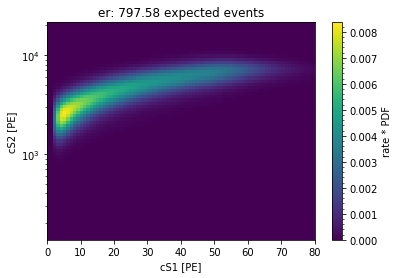

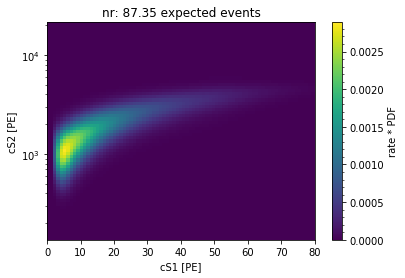

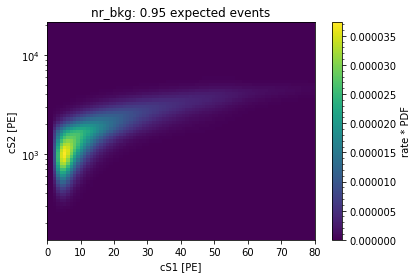

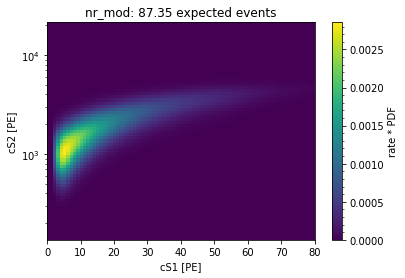

In [4]:
remake_hists = False
    
# Restore histograms
fn = f'hists_1e6_{WIMP_MASS}GeV_326elife.pkl'
with open(fn, mode='rb') as f:
    hists = pickle.load(f)
    for dname, q in dsets.items():
        if dname not in hists:
            continue
        q['mh'] = hists[dname]

        
def std_axes():
    plt.yscale('log')
    plt.xlabel("cS1 [PE]")
    plt.ylabel("cS2 [PE]")
        
for dname, q in dsets.items():

    if remake_hists or not 'mh' in q:
        print(f"Building histogram for {dname}")
        
        mh = Histdd(bins=(
            np.linspace(0, 80, 81 + 1),
            np.geomspace(10**1.7 / (1 - 0.63),
                         10**3.9 / (1 - 0.63), 
                         70)))
        
        n_batches = 100 if dname == 'er' else 40
        trials_per_batch = int(1e6)

        for _ in tqdm(range(n_batches)):
            d = q['source'].simulate(trials_per_batch)
            add_corrected_signals(d)
            mh.add(d['cs1'], d['cs2'])
        
        # Convert to PDF
        mh /= mh.bin_volumes() * trials_per_batch * n_batches

        # Multiply by total expected event rate
        # (from the source, i.e. before correcting for efficiencies)
        mh *= q['source'].mu_before_efficiencies()

        q['mh'] = mh
    

    q['events_per_bin'] = q['mh'] * q['mh'].bin_volumes()
    q['mh'].plot(cblabel='rate * PDF')
    plt.title(f"{dname}: {q['events_per_bin'].n:.02f} expected events")
    std_axes()

    plt.show()
    

# # If you save histograms, remember to download them!
# with open('hists_1e6_20200205_15GeV.pkl', mode='wb') as f:
#     pickle.dump({
#         k: v['mh'] 
#         for k, v in dsets.items()}, f)

  * Be careful about models 'cut off' in cS1 / cS2 -- to run with these, you have to implement cS1/cS2 cuts properly in flamedisx. See e.g. https://github.com/FlamTeam/flamedisx/pull/63 for a cS1 >= 2 PE requirement.
  * The ROC curves will depend on the extent of the ER spectrum. If you include more high-energy ER events that can be discriminated anyway, the ER leakage in any likelihood will go down. The key figure of merit we are trying to derive here, the decrease in ER leakage at ~50 % NR acceptance when switching to the full likelihood, should be unaffected by this.

### Histogram-based discrimination

For the 2D histograms, we can quickly derive discrimination ROC curves.

ER background vs WIMPs:

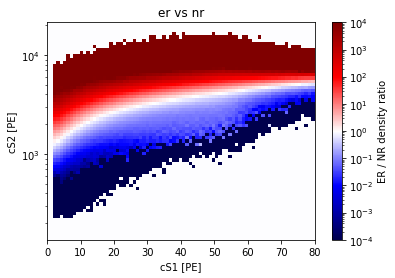

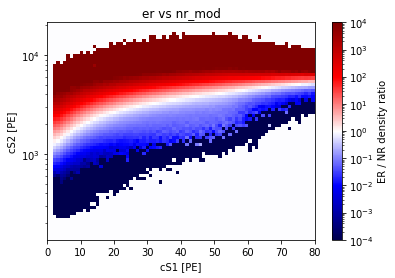

In [5]:
for dname in nr_conditions:
    q = dsets[dname]
    q['signal_background_ratio'] = ratio = \
        (dsets['er']['mh'] + 1e-20)/(q['mh'] + 1e-20)
    q['histogram_ordering'] = np.argsort(ratio.histogram.ravel())

    ratio.plot(log_scale=True, cmap=plt.cm.seismic, 
           vmin=1e-4, vmax=1e4, cblabel='ER / NR density ratio')
    std_axes()
    plt.title(f"er vs {dname}")
    plt.show()

NR background vs WIMPs:

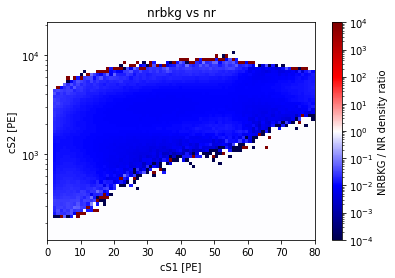

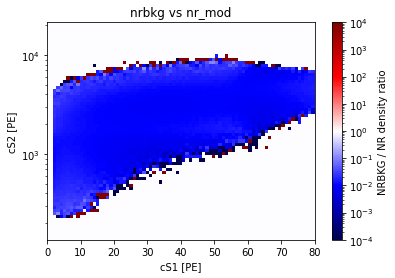

In [6]:
for dname in nr_conditions:
    q = dsets[dname]
    q['signal_background_ratio_nrbkg'] = ratio = \
        (dsets['nr_bkg']['mh'] + 1e-20)/(q['mh'] + 1e-20)
    q['histogram_ordering_nrbkg'] = np.argsort(ratio.histogram.ravel())

    ratio.plot(log_scale=True, cmap=plt.cm.seismic, 
           vmin=1e-4, vmax=1e4, cblabel='NRBKG / NR density ratio')
    std_axes()
    plt.title(f"nrbkg vs {dname}")
    plt.show()

Modulating vs non-modulating WIMPs. This should show statistical errors only, since the 2D histograms do not have time.

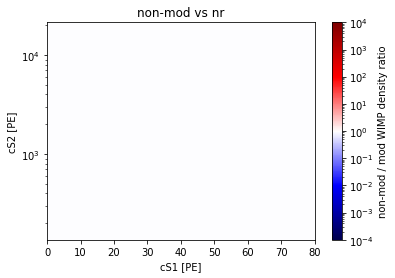

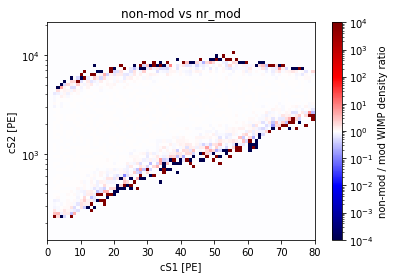

In [7]:
# For NR WIMP vs Modulating WIMP
for dname in nr_conditions:
    q = dsets[dname]
    q['signal_background_ratio_mod'] = ratio = \
        (dsets['nr']['mh'] + 1e-20)/(q['mh'] + 1e-20)
    q['histogram_ordering_mod'] = np.argsort(ratio.histogram.ravel())

    ratio.plot(log_scale=True, cmap=plt.cm.seismic, 
           vmin=1e-4, vmax=1e4, cblabel='non-mod / mod WIMP density ratio')
    std_axes()
    plt.title(f"non-mod vs {dname}")
    plt.show()

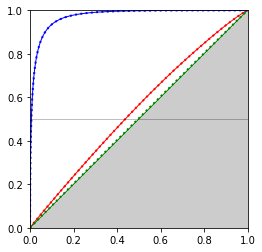

In [8]:
plt.figure()
plt.gcf().patch.set_facecolor('white')

def hist_to_cdf(hist, ordering):
    return np.cumsum(hist.histogram.ravel()[ordering])/hist.n

for dname in nr_conditions:
    
    q = dsets[dname]
    q['roc_from_histogram'] = (
        hist_to_cdf(dsets['er']['events_per_bin'], q['histogram_ordering']),
        hist_to_cdf(q['events_per_bin'], q['histogram_ordering']))

    if dname == 'nr_mod':
        style = dict(linestyle=':', linewidth=2)
    else:
        style = dict(linestyle='-', linewidth=1)
    
    plt.plot(*q['roc_from_histogram'], label='er vs. ' + dname,
             c='b', **style)

    q['roc_from_histogram_nrbkg'] = (
        hist_to_cdf(dsets['nr_bkg']['events_per_bin'], q['histogram_ordering_nrbkg']),
        hist_to_cdf(q['events_per_bin'], q['histogram_ordering_nrbkg']))

    plt.plot(*q['roc_from_histogram_nrbkg'], label='nr bkg vs. ' + dname,
             c='r', **style)
    
    q['roc_from_histogram_mod'] = (
        hist_to_cdf(dsets['nr']['events_per_bin'], q['histogram_ordering_mod']),
        hist_to_cdf(q['events_per_bin'], q['histogram_ordering_mod']))

    plt.plot(*q['roc_from_histogram_mod'], label='non-mod vs. ' + dname,
             c='g', **style)


def fill_roc(xmin=0, scale=1):
    if xmin == 0:
        x = np.linspace(0, 1, 1000)
    else:
        x = np.geomspace(xmin, 1, 1000)
    plt.fill_between(x * scale, 
                     x * 0, 
                     x * scale, alpha=0.2, linewidth=0, 
                     color='k')
    
fill_roc()
    
plt.gca().set_aspect('equal')
plt.axhline(0.5, alpha=0.5, c='k', linewidth=0.5)
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.show()

As expected, there is no difference between NR with and without modulation, since the 2D histograms do not see time.

## Flamedisx-based discrimination

  * `dsets` contains a flamedisx Source and a (cS1, cS2) histogram of the four different sources:
    * `er`
    * `nr` (fake non-modulating WIMP)
    * `nr_bkg` (neutron background)
    * `nr_mod` (WIMP)
  * For each source, we will now simulate some data, and add columns to the dataframe for:
    * `l_mh_XX`: differential rate in the 2D histogram of source XX at this event
    * `l_full_XX`: differential rate from flamedisx of source XX at this event
    `

In [9]:
remake_data = False
n_trials_events = int(1e6) # if have_gpu else int(1e3)

# Load earlier results: 
fn = f'discstudy_1e6_maxsigma5_{WIMP_MASS}GeV_326elife.pkl.gz'
with gzip.open(fn, mode='rb') as f:
    q = pickle.load(f)
    for k, v in q.items():
        dsets[k]['data'] = v

for dname, q in dsets.items():
    # Get simulated data
    if remake_data or 'data' not in q:
        print(f"Simulating data for {dname}")
        q['data'] = sim_data = q['source'].simulate(n_trials_events)
        sim_data['event_time'] += int(5e9)  # Add 5 seconds
        add_corrected_signals(sim_data)
        
        # Ensure cs1 and cs2 are in range of the histogram
        # to avoid extrapolation in multihist's lookup.
        # NB: we are assuming both histograms have the same binning here!
        bes = q['mh'].bin_edges
        mask = (
            (bes[0][0] <= sim_data['cs1']) & (sim_data['cs1'] < bes[0][-1]) &
            (bes[1][0] <= sim_data['cs2']) & (sim_data['cs2'] < bes[1][-1]))
        print(f"{dname}: Throwing out {100 * (~mask).sum() / len(sim_data):.2f}% of events")
        q['data'] = sim_data[mask].copy()
    sim_data = q['data']
    
    # Compute differential rates ("likelihoods") for all models ("sources")
    for likelihood_dsetname, likelihood_dset in dsets.items():
        sim_data['l_mh_' + likelihood_dsetname] = likelihood_dset['mh'].lookup(
            sim_data['cs1'], sim_data['cs2'])

        key = 'l_full_' + likelihood_dsetname
        if key not in sim_data:
            print(f"Computing likelihood of {dname} data under {likelihood_dsetname} model")
            likelihood_dset['source'].set_data(sim_data.copy())
            sim_data[key] = likelihood_dset['source'].batched_differential_rate()
        
    # Compute ratios of differential rates ("likelihood ratios")
    # for both histogram- and flamedisx based method.
    for nrc in nr_conditions:
        sim_data[f'lr_mh_{nrc}'] = sim_data['l_mh_er'] / sim_data[f'l_mh_{nrc}']
        sim_data[f'lr_full_{nrc}'] = sim_data['l_full_er'] / sim_data[f'l_full_{nrc}']

        sim_data[f'lr_mh_nr_{nrc}'] = sim_data['l_mh_nr_bkg'] / sim_data[f'l_mh_{nrc}']
        sim_data[f'lr_full_nr_{nrc}'] = sim_data['l_full_nr_bkg'] / sim_data[f'l_full_{nrc}']

    sim_data[f'lr_mh_mod'] = sim_data['l_mh_nr'] / sim_data[f'l_mh_nr_mod']
    sim_data[f'lr_full_mod'] = sim_data['l_full_nr'] / sim_data[f'l_full_nr_mod']
    
# # Save results to gzipped pickle. Compression takes a while; download longer.
# # Don't forget to download it!!
# with gzip.open('discstudy_20200205_1e6_maxsigma5_15GeV.pkl.gz', mode='wb') as f:
#     pickle.dump({dname: q['data']
#                  for dname, q in dsets.items()},
#                 f)

## Compare differential rates

Compare differential rates. There will be an offset because (cS1, cS2) and (S1, S2) have different ranges/means -- so the rates are differential with respect to different coordinates.

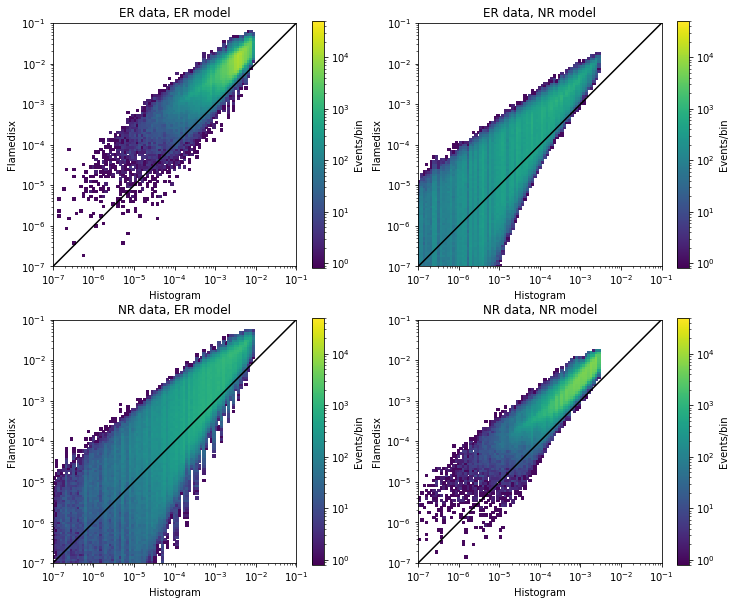

In [10]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))

for dn_i, dname in enumerate(['er', 'nr']):
    for lh_i, lh_name in enumerate(['er', 'nr']):
        ax = axes[dn_i, lh_i]
        plt.sca(ax)
        
        q = dsets[dname]['data']
        if dname == 'er' and lh_name == 'er':
            q_s = q.copy()
        y, x = q[f'l_full_{lh_name}'], q[f'l_mh_{lh_name}']

        Histdd(x, y,
               bins=(np.geomspace(1e-7, 1e-1, 100),
                     np.geomspace(1e-7, 1e-1, 100))).plot(
            log_scale=True, cblabel='Events/bin',
            vmin=0.8, vmax=n_trials_events * 0.05)
        
        #xs = np.geomspace(1e-7, 1e-1, 100)
        #plt.plot(xs, xs * 1e2, 'r')
        #plt.plot(xs, xs * 1e1, 'r')
        #plt.plot(xs, xs * 2.8, 'r')

        plt.plot([1e-7, 1e-1], [1e-7, 1e-1], 'k-')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel("Histogram")
        plt.ylabel("Flamedisx")
        plt.ylim(1e-7, 1e-1)
        plt.xlim(1e-7, 1e-1)
        plt.title(f"{dname.upper()} data, {lh_name.upper()} model")
        plt.gca().set_aspect(1)
plt.show()

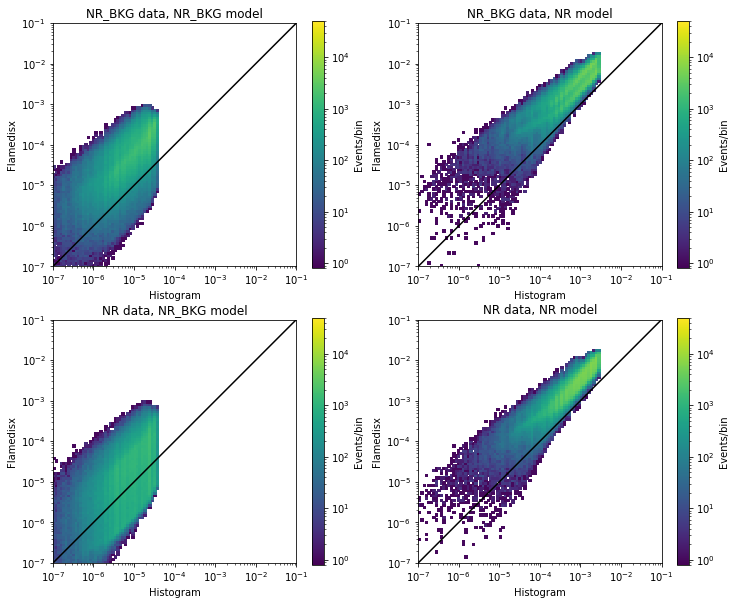

In [11]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))

min_ll = 1e-7
for dn_i, dname in enumerate(['nr_bkg', 'nr']):
    for lh_i, lh_name in enumerate(['nr_bkg', 'nr']):
        ax = axes[dn_i, lh_i]
        plt.sca(ax)
        
        q = dsets[dname]['data']
        y, x = q[f'l_full_{lh_name}'], q[f'l_mh_{lh_name}']

        Histdd(x, y,
               bins=(np.geomspace(min_ll, 1e-1, 100),
                     np.geomspace(min_ll, 1e-1, 100))).plot(
            log_scale=True, cblabel='Events/bin',
            vmin=0.8, vmax=n_trials_events * 0.05)

        plt.plot([min_ll, 1e-1], [min_ll, 1e-1], 'k-')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel("Histogram")
        plt.ylabel("Flamedisx")
        plt.ylim(min_ll, 1e-1)
        plt.xlim(min_ll, 1e-1)
        plt.title(f"{dname.upper()} data, {lh_name.upper()} model")
        plt.gca().set_aspect(1)
plt.show()

797674


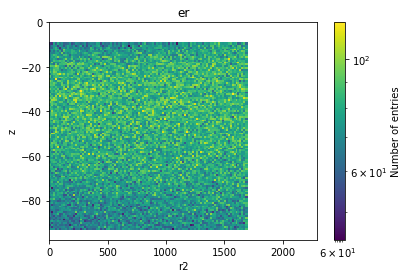

667477


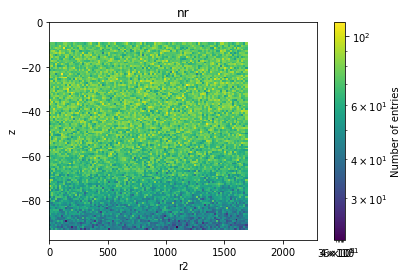

502438


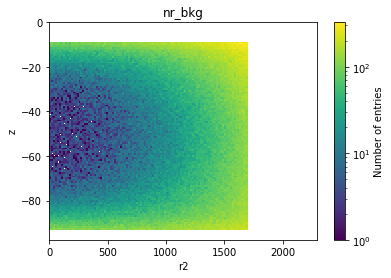

666766


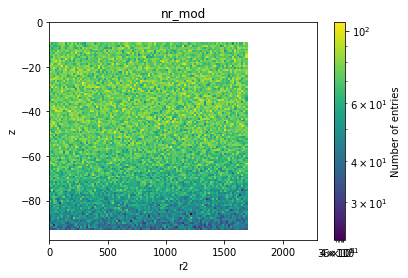

In [12]:
# Check spatial distribution of sources
for dname in ['er', 'nr', 'nr_bkg', 'nr_mod']:
    q = dsets[dname]['data']
    print(len(q))
    Histdd(q['r']**2, q['z'], bins=100, axis_names=['r2', 'z']).plot(log_scale=True)
    plt.title(dname)
    plt.xlim(0, spatial_data['tpc_radius']**2)
    plt.ylim(-spatial_data['tpc_length'], 0)
    plt.show()

Log likelihood ratio histograms for ER and NR data under both likelihoods below. Note many events are at the edges for the histogram likelihood; for these either the NR or ER histogram was zero, and we clip the likelihood ratio.

Found 0 NaNs for mh:er
Found 0 NaNs for mh:nr
Found 0 NaNs for full:er
Found 0 NaNs for full:nr
Found 0 NaNs for full:er
Found 0 NaNs for full:nr_mod


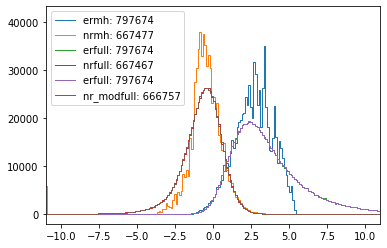

In [13]:
clip_exp = 11

plt.gcf().patch.set_facecolor('white')
for lt, nrc, color in [['mh', 'nr', 'b'], 
                       ['full', 'nr', 'g'], 
                       ['full', 'nr_mod', 'purple']
                      ]:
    hists = dict()
    cis = dict()
    for dname, q in dsets.items():
        if dname not in ('er', nrc):
            continue

        d = q['data'][f'lr_{lt}_{nrc}']
        print(f"Found {np.sum(np.isnan(d))} NaNs for {lt}:{dname}")
        hists[dname] = Hist1d(
            np.log10(d.clip(10**-clip_exp, 10**clip_exp).values.astype('float')),
            bins=np.linspace(-clip_exp, clip_exp + 0.1, 200))
        hists[dname].plot(label=f"{dname}{lt}: {hists[dname].n}")
#plt.yscale('log')
plt.xlim(-clip_exp, clip_exp)
plt.legend()

#plt.axvline(-12, color='k', linestyle='--')
#plt.axvline(-11, color='k', linestyle='--')

plt.show()

## ROC Curves

In [14]:
def binom_interval(success, total, conf_level=0.95):
    """Confidence interval on binomial - using Jeffreys interval
    Code stolen from https://gist.github.com/paulgb/6627336
    Agrees with http://statpages.info/confint.html for binom_interval(1, 10)
    """
    # TODO: do we need a special case for success = 0 or = total? see wikipedia
    quantile = (1 - conf_level) / 2.
    lower = stats.beta.ppf(quantile, success, total - success + 1)
    upper = stats.beta.ppf(1 - quantile, success + 1, total - success)
    
    # If something went wrong with a limit calculation, report the trivial limit
    lower[np.isnan(lower)] = 0
    upper[np.isnan(upper)] = 1
    return lower, upper


def colormap(*colors, discrete=False):
    """Return colormap that interpolates between colors.
    :param discrete: if True, return a discrete colormap
    (i.e. use nearest-neighbour rather than linear interpolation)
    """
    return matplotlib.colors.LinearSegmentedColormap.from_list(
        'CustomMap', colors, N=len(colors) if discrete else 256)


class ROCCurve:

    def __init__(self, 
                 likelihood_type, 
                 background, 
                 signal='nr_mod',
                 n_bins=10_000, 
                 clip=1e-20):
        """
        :param likelihood: 'full' (flamedisx) or 'mh' (2Dhistogram)
        :param background: 'er', 'nr', or 'nr_bkg'
        :param signal: signal source to use. Probably nr_mod, for WIMPs.
        """
        assert background in 'er nr nr_bkg'.split()
        self.background = background
        self.signal = signal

        self.hists = dict()
        self.cdfs = dict()
        self.cdf_intervals = dict()
        self.bins = np.concatenate(
            [np.linspace(np.log10(clip / 1.01), -0.1, n_bins // 3),
             np.linspace(-0.1, 0.1, n_bins // 3)[1:-1],
             np.linspace(0.1, np.log10((1/clip) * 1.01), n_bins // 3)])
        
        for dname in [background, signal]:
            d = dsets[dname]['data']
            l_bkg = d[f'l_{likelihood_type}_{background}'].values.clip(clip, 1/clip)
            
            l_sig = d[f'l_{likelihood_type}_{signal}'].values.clip(clip, 1/clip)
            # NB: we're using log10 here, for convenience!
            log_l_ratio = np.log10(l_bkg) - np.log10(l_sig)

            self.hists[dname] = Hist1d(
                log_l_ratio,
                bins=self.bins)

            self.cdfs[dname] = self.hists[dname].cumulative_density
            self.cdf_intervals[dname] = np.stack(binom_interval(
                np.cumsum(self.hists[dname].histogram),
                self.hists[dname].n, 
                conf_level=.68))
         
    def _xy(self):
        return self.cdfs[self.background], self.cdfs[self.signal]
    
    def leakage_at(self, acceptance):
        return np.interp(
            acceptance, 
            xp=self.cdfs[self.signal],
            fp=self.cdfs[self.background])
#         acc_i = np.argmin(np.abs(self.cdfs[self.signal] - acceptance))
#         return self.cdfs[self.background][acc_i]
    
    def plot(self, errors=False, **style):
        style = {'color': dsets[self.background]['color'],
                 'label': dsets[self.background]['name'],
                 'linewidth': 1,
                 **style}
        x, y = self._xy()
        scale = 100
        if errors:
            plt.errorbar(x * scale, y * scale,
                         xerr=np.abs(self.cdf_intervals[self.background] - x),
                         yerr=np.abs(self.cdf_intervals[self.signal] - y),
                         **style)
        else:
            plt.plot(x * scale, y * scale, **style)
        
    
rocs = {
    likelihood_type: {
        background_name: ROCCurve(likelihood_type, background_name)
        for background_name in ('er', 'nr_bkg', 'nr')}
    for likelihood_type in ['mh', 'full']}

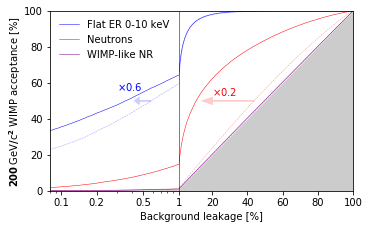

In [15]:
def plot_rocs():
    for background_name in ('er', 'nr_bkg', 'nr'):
        rocs['mh'][background_name].plot(linewidth=0.5, alpha=0.4, linestyle='--', label='')
        rocs['full'][background_name].plot(linewidth=0.5)

        
def reduction_indicator(background_type='er', 
                        ytext=60, xtext=None,
                        fontsize=None,
                        length_reduction=0.8, 
                        left_reduction=0.95,
                        linewidth=None,
                        width=0.001,
                        **kwargs):
    leakage_mh = rocs['mh'][background_type].leakage_at(0.5) * 100
    leakage_full = rocs['full'][background_type].leakage_at(0.5) * 100
    reduction = leakage_full / leakage_mh
    if xtext is None:
        xtext = (leakage_mh + leakage_full)/2
    
    style = {**dict(head_width=4, 
                    length_includes_head=True,
                    color=dsets[background_type]['color']),
             **kwargs}

    plt.text(xtext,
             ytext, 
             r'$\times$' '%0.1f' % reduction,
             fontsize=fontsize,
             ha='center', va='center', 
             color=style['color'])
    
    style['color'] = colormap('w', style['color'])(0.2)
    plt.arrow(leakage_mh, 50, (leakage_full - leakage_mh) * length_reduction, 0,
              width=width,
              **style)

tick_top = False    
        
fig, axes = plt.subplots(
    1, 2, 
    sharey=True, 
    figsize=(5,  5/golden_ratio),
    gridspec_kw=dict(width_ratios=[1, 1.35]))

x_bounds = (0.08, 1, 100)


##
# Right plot (linear scale)
##
ax = axes[1]
plt.sca(axes[1])

plot_rocs()
fill_roc(xmin=x_bounds[1]/100, scale=100)
reduction_indicator('nr_bkg', ytext=55, 
                    length_reduction={30: 0.8, 200: 0.9}[WIMP_MASS],
                    xtext={200: None, 30: 20}[WIMP_MASS])

plt.xlim(x_bounds[1], 100)
plt.ylim(0, 100)

ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
plt.axvline(x_bounds[1], linestyle='-', c='k', alpha=1, linewidth=0.5)

# ##
# # Easter egg in right plot -- fail
# ##
# ref = 50.4
# dx = 0.3
# plt.plot([ref - dx, ref], [ref, ref], 
#          c='green', linewidth=0.01)

# data_to_figure = ax.transData + fig.transFigure.inverted()
# center = data_to_figure.transform([ref, ref])
# scale = 100
# w, h = dx/scale, dx/(3*scale)
# egg_ax = plt.gcf().add_axes((center - 0.5 * np.array([w, h])).tolist()
#                             + [w, h])
# image = plt.imread('egg.png')
# egg_ax.imshow(image, interpolation='none')
# egg_ax.axis('off')


##
# Left plot (log scale)
##

ax = axes[0]
plt.sca(ax)

plot_rocs()
fill_roc(xmin=x_bounds[0]/100, scale=100)
reduction_indicator('er',
                    head_length={200: 0.04, 30: 0.02}[WIMP_MASS], 
                    xtext={200: 0.38, 30: 0.14}[WIMP_MASS], 
                    ytext={200: 58, 30: 59}[WIMP_MASS],
                    length_reduction={200: 0.7, 30: 0.82}[WIMP_MASS])

plt.legend(loc='upper left', frameon=False)

plt.xscale('log')
plt.xlim(x_bounds[0], x_bounds[1])
plt.xticks([0.1, 0.2, 0.5, 1])
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
ax.spines['right'].set_visible(False)
plt.axvline(x_bounds[1], linestyle='-', c='k', alpha=1, linewidth=0.5)

# Finalize plot

if tick_top:
    for ax in axes:
        ax.xaxis.tick_top()

plt.tight_layout()
plt.subplots_adjust(wspace=0)

# Common hidden axis to position x-label correctly
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Background leakage [%]", labelpad=27 if tick_top else None)
if tick_top:
    plt.gca().xaxis.set_label_position('top') 
plt.ylabel(r'$\bf{' + str(WIMPSource.mw) + r"\,\mathrm{GeV}/\mathrm{c}^2}$ WIMP acceptance [%]")


plt.savefig(f"roc_combined_{WIMP_MASS}gev.pdf", dpi=200, 
            bbox_inches='tight')

## Compare sensitivity

Create likelihoods for:
  1. ER vs NR histogram-based
  2. ER vs NR flamedisx
  3. ER vs NR-mod histogram-based -- could omit, should be same as (1)
  4. ER vs NR-mod flamedisx

Sources are represented by `ColumnSource`s, with a simulate method that draws from `dsets[dname]['data']`.


In [16]:
class FastSource(fd.ColumnSource):

    def _differential_rate(self, data_tensor, ptensor):
        return tf.clip_by_value(self._fetch(self.column, data_tensor) * self.scale_by,
                                1e-20, 1e20)

    def random_truth(self, n_events, fix_truth=None, **params):
        if fix_truth is not None or len(params):
            raise NotImplementedError
        return dsets[self.dname]['data'].sample(n_events, replace=True)

mu_of_source = dict(er=1, nr=1, nr_mod=1, nr_bkg=1)
likelihood_types = ('mh', 'full')

fast_sources = {
    ltype: {
        dname: type(
            f'FS_{dname}_{ltype}', 
            (FastSource,), 
            dict(column=f'l_{ltype}_{dname}',
                 dname=dname,
                 # Adjust mu to the desired value, scaling
                 # the differential rate accordingly
                 mu=mu_of_source[dname],
                 scale_by=mu_of_source[dname]/dsets[dname]['events_per_bin'].n,
                 ))
        for dname in dsets.keys()}
    for ltype in likelihood_types}

likelihoods = {
    ltype: {
        nrc: fd.LogLikelihood(
            sources=dict(er=fast_sources[ltype]['er'],
                         nr=fast_sources[ltype][nrc],
                         nr_bkg=fast_sources[ltype]['nr_bkg'],
                         ),
            free_rates=('er', 'nr', 'nr_bkg'),
            # max_sigma and n_trials are irrelevant for ColumnSource
            batch_size=10_000)
        for nrc in nr_conditions}
    for ltype in likelihood_types}


Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]


In [17]:
# # Check simulated events are reasonable
# ll = likelihoods['full']['nr']
# for sname, color in [['er', 'b'], ['nr', 'r']]:
#     d = ll.sources[sname].simulate(1000)
#     plt.scatter(d['cs1'], d['cs2'], color=color, s=1)
# likelihoods['full']['nr']
# d = ll.simulate()
# plt.scatter(d['cs1'], d['cs2'], s=1, c='g')
# from collections import Counter
# Counter(d['source'].values)

Time for 400 trials, 1e4 ER events /trials, minuit, default tolerance:
  * master 23 January, colab GPU: 41 minutes
  * trace_likelihood 25 January, Jelle's laptop: 5 minutes

In [18]:
fd.inference.LOWER_RATE_MULTIPLIER_BOUND = 1e-3

n_trials = 10000
allow_failure = False

rm_scale = 15.  # Exposure scale [tonne year]
er_bkg_reduction = 8.2  # ER background reduction from Xe1T to XenT
nr_bkg_reduction = 40   # NR background reduction from Xe1T to XenT
discovery = True

xtol=1e-4
gtol=1e-3

n_bestfit_failures = 0
n_cond_bestfit_failures = 0
n_guess_limit_failures = 0
n_limit_failures = 0


In [ ]:
#nrs = np.linspace(1e-9, 24, 40)
#ers = np.linspace(6100, 6500, 40)
#xx, yy = np.meshgrid(nrs, ers)

import pandas as pd

sensi_results = {
    ltype: {
        nrc: pd.DataFrame(
            dict(t=np.zeros(n_trials),
                 bestfit_nr=np.zeros(n_trials),
                 bestfit_er=np.zeros(n_trials),
                 condfit_er=np.zeros(n_trials),
                 limit=np.zeros(n_trials))).to_records()
        for nrc in nr_conditions}
    for ltype in likelihood_types}

#(er=627, nr=1, nr_mod=1, nr_bkg=1.4)
truth = dict(nr_rate_multiplier=0.,
             er_rate_multiplier=627. * rm_scale / er_bkg_reduction,
             nr_bkg_rate_multiplier=1.4 * rm_scale / nr_bkg_reduction)

# Expected total number of wimps at reference xsec of 1e-45
nwimps = 627 * rm_scale * dsets['nr_mod']['events_per_bin'].n / dsets['er']['events_per_bin'].n
if discovery:
    nwimps *= 2e-47 / 1e-45  # desired xsec / wimprates xsec
    truth['nr_rate_multiplier'] = nwimps

import warnings

for trial_i in tqdm(range(n_trials)):
    # The nr model choice changes what events we need to pick from,
    # so this has to be the outer loop.
    for nrc in nr_conditions: 

        # Draw simulated events.
        # The histogram and flamedisx likelihood draw from the same
        # event reservoir (they just look at different columns later)
        d = likelihoods['mh'][nrc].simulate(**truth)

        for ltype in likelihood_types:
            #if discovery:  # Only use mh nr and full nrmod, maybe also for sensi.. yeah
            if f'{ltype}_{nrc}' not in ['mh_nr', 'full_nr_mod']:
                continue
            
            q = sensi_results[ltype][nrc]

            ll = likelihoods[ltype][nrc]
            ll.set_data(d)

            guess = dict(nr_rate_multiplier=3, 
                         er_rate_multiplier=len(d))
            
            try:
                bf = ll.bestfit(
                    guess=guess,
                    fix=dict(nr_bkg_rate_multiplier=truth['nr_bkg_rate_multiplier']),
                    optimizer_kwargs=dict(options=dict(gtol=gtol, xtol=xtol)),
                    allow_failure=allow_failure,
                )
            except:
                n_bestfit_failures += 1
                print("bestfit failure")
                continue
            q['bestfit_nr'][trial_i] = bf['nr_rate_multiplier']
            q['bestfit_er'][trial_i] = bf['er_rate_multiplier']
            
            #continue
            
            # lls = [-2*ll(nr_rate_multiplier=x,
            #              er_rate_multiplier=y,
            #              nr_bkg_rate_multiplier=truth['nr_bkg_rate_multiplier'])
            #        for (x, y) in np.array([xx.ravel(), yy.ravel()]).T]
            # ll_min = min(lls)
            # lls = np.reshape(lls, (40, 40))
            # 
            # grid_min = np.unravel_index(np.argmin(lls), lls.shape)
            # 
            # plt.figure(figsize=(10, 8))
            # plt.pcolormesh(xx, yy, (lls - ll_min), vmin=0, vmax=16)
            # plt.colorbar()
            # plt.plot([3, 0], [truth['er_rate_multiplier'],
            #                   truth['er_rate_multiplier']], 'o', color='orange')
            # plt.plot(nrs[grid_min[1]], ers[grid_min[0]], 'go')
            # plt.plot(bf['nr_rate_multiplier'], bf['er_rate_multiplier'], 'ro')
            # plt.title(f'{ltype} {nrc}')
            # plt.show()
            # 
            # continue

            # Compute best fit nuisance params conditional on truth 
            # and test statistic value (which depends on this)
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    cf = ll.bestfit(
                        guess=dict(er_rate_multiplier=bf['er_rate_multiplier']),
                        fix=dict(nr_rate_multiplier=0 if discovery else truth['nr_rate_multiplier'],
                                 nr_bkg_rate_multiplier=truth['nr_bkg_rate_multiplier']),
                        optimizer_kwargs=dict(options=dict(gtol=gtol, xtol=xtol)),
                        allow_failure=allow_failure)
            except:
                n_cond_bestfit_failures += 1
                print("conditional bestfit failure")
            q['condfit_er'][trial_i] = cf['er_rate_multiplier']
            q['t'][trial_i] = 2 * (ll(**bf) - ll(**cf))
            
            if discovery:
                continue
            
            try:
                guess_limit = ll.limit(
                    'nr_rate_multiplier', 
                    bestfit=bf,
                    fix={k: v for k, v in bf.items()
                         if k != 'nr_rate_multiplier'},
                    optimizer_kwargs=dict(options=dict(gtol=gtol, xtol=xtol)),
                    allow_failure=allow_failure)
            except:
                n_guess_limit_failures += 1
                print("guess limit failure")
                continue
            
            try:
                q['limit'][trial_i] = ll.limit(
                    'nr_rate_multiplier', 
                    bestfit=bf,
                    guess={**bf, **dict(nr_rate_multiplier=guess_limit)},
                    fix=dict(nr_bkg_rate_multiplier=truth['nr_bkg_rate_multiplier']),
                    optimizer_kwargs=dict(options=dict(gtol=gtol, xtol=xtol)),
                    allow_failure=False)
            except:
                n_limit_failures += 1
                print("limit failure")
                
            continue
            
            lls = [-2*ll(nr_rate_multiplier=x,
                         er_rate_multiplier=y,
                         nr_bkg_rate_multiplier=truth['nr_bkg_rate_multiplier'])
                   for (x, y) in np.array([xx.ravel(), yy.ravel()]).T]
            m2ll_best = -2*ll(**bf)
            wilks_crit = stats.norm.ppf(0.9) ** 2
            
            fun = (np.array(lls) - (m2ll_best + wilks_crit))**2
            fun_min = min(fun)
            fun = np.reshape(fun, (40, 40))
            
            fun -= xx * 0.01
            
            grid_min = np.unravel_index(np.argmin(fun), fun.shape)
            
            plt.figure(figsize=(10, 8))
            plt.pcolormesh(xx, yy, (fun - fun_min), vmin=0, vmax=9)
            plt.colorbar()
            plt.plot([3, 0], [truth['er_rate_multiplier'],
                              truth['er_rate_multiplier']], 'o', color='orange', label='truth and guess')
            plt.plot(nrs[grid_min[1]], ers[grid_min[0]], 'go', label='grid minimum')
            plt.plot(bf['nr_rate_multiplier'], bf['er_rate_multiplier'], 'ro', label='bestfit')
            plt.axvline(q['limit'][trial_i], color='r', linestyle='--', label='limit')
            plt.legend()
            plt.title(f'{ltype} {nrc}')
            plt.show()

print("n bestfit failures", n_bestfit_failures)
print("n conditional bestfit failures", n_cond_bestfit_failures)
print("n guess limit failures: ", n_guess_limit_failures)
print("n limit failures: ", n_limit_failures)

In [20]:
# fn = 'sensi_results_20200219_10k_15ty_200GeV.pkl'
# #fn = 'sensi_results_20200219_10k_15ty_200GeV.pkl'

In [21]:
# with open(fn, mode='wb') as f:
#     pickle.dump(sensi_results, f)

In [22]:
# with open(fn, mode='rb') as f:
#     sensi_results = pickle.load(f)

In [23]:
# list of sensi files for different exposures
exposures = [5, 
             10, 15, 20]  #, 25]  # tonne year
disc_sigmas = {k: dict() for k in exposures}
for exp in exposures:
    name = f'disc_results_20200219_10k_{exp}ty_200GeV_2e-47.pkl'  # [5, 10, 15, 20]
    #name = f'sensi_results_20200219_10k_{exp}ty_200GeV.pkl'  # [5, 10, 15, 20]
    with open(name, mode='rb') as f:
        disc_res = pickle.load(f)

    for (ltype, nrc) in [('mh', 'nr'), ('full', 'nr_mod')]:            
        q_t = disc_res[ltype][nrc]['t']
        q_t = q_t[np.isfinite(q_t) & (q_t >= 0)]
        sigmas = q_t**0.5
        
        percentiles = np.percentile(sigmas, stats.norm.cdf([-2, -1, 0, 1, 2])*100)
        disc_sigmas[exp][ltype] = percentiles

In [24]:
discovery = True

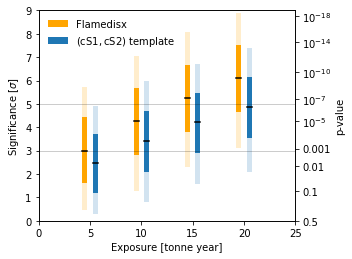

In [29]:
delta = 0.25  # Width of the bars
offset_multiplier = 2
label_set = False
plt.figure(figsize=(5, 6/golden_ratio))
for i in [3, 5]:
    plt.axhline(i, color='k', alpha=0.2, linestyle='-', linewidth=1)
    
for exp in exposures:
    for (ltype, offset) in [
                ('full', -offset_multiplier*delta),
                ('mh', offset_multiplier*delta), 
                
    ]:
        p = disc_sigmas[exp][ltype]
        if ltype == 'mh':
            c, l = ('C0', '$(\mathrm{cS1}, \mathrm{cS2})$ template') 
        else:
            c, l = ('orange', 'Flamedisx')
        plt.fill_between([exp-delta+offset, exp+delta+offset], 
                         # The 2*[] double the length without changing the values
                         2*[p[4]], 2*[p[0]],
                         color=c, alpha=0.2, lw=0)
        plt.fill_between([exp-delta+offset, exp+delta+offset], 
                         2*[p[3]], 2*[p[1]],
                         color=c, alpha=1, lw=0, label=l if not label_set else None)
        plt.plot([exp-delta+offset, exp+delta+offset], 
                 2*[p[2]], 
                 color='k')
    label_set = True

def s_to_p(s):
    return stats.norm.cdf(-s) #stats.chi2(1).sf(s**2)/2    
    
def p_to_s(p):
    return -stats.norm.ppf(p)
    
plt.xlim(0, max(exposures)+5)
plt.ylim(0, 9)
plt.yticks(np.arange(9.2))
plt.xlabel('Exposure [tonne year]')
plt.ylabel('Significance [$\sigma$]')
plt.legend(frameon=False, loc='upper left')

#secax = plt.gca().secondary_yaxis('right', functions=(s_to_p, p_to_s))
#print(secax.get_yticks())
secax = plt.gca().twinx()
plt.sca(secax)
plt.ylabel('p-value')
plt.ylim(0, 9)
ps = [0.5, 0.1, 0.01, 1e-3, 1e-5, 1e-7, 1e-10, 1e-14, 1e-18]
p_labels = ['0.5', '0.1', '0.01', '0.001', 
             '$10^{-5}$',
            '$10^{-7}$', '$10^{-10}$', '$10^{-14}$', '$10^{-18}$']
plt.yticks(p_to_s(np.array(ps)), p_labels)
#secax.set_yticklabels(['%.2g' % s_to_p(i) for i in range(10)])

plt.tight_layout()
plt.savefig('discovery_exposure_sig_10k.pdf', bbox_inches='tight')
plt.show()

In [106]:
1 - order

array([1.00000000e+00, 9.99899990e-01, 9.99799980e-01, ...,
       2.00020002e-04, 1.00010001e-04, 0.00000000e+00])

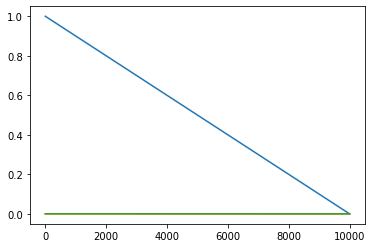

In [117]:
plt.plot(order)
plt.plot(low)
plt.plot(high)

In [138]:
(t < 0).sum()

6202

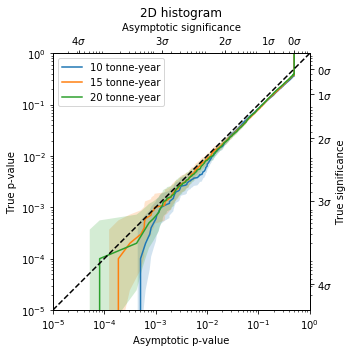

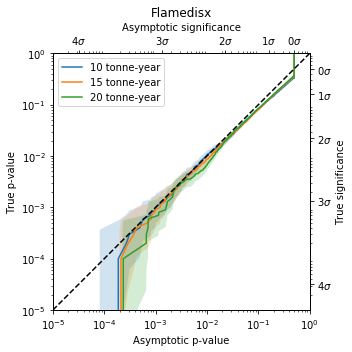

In [143]:
def wilks_p(t):
    return 1 - (0.5 + 0.5 * stats.chi2(1).cdf(t))

log = True

for mh in True, False:

    plt.figure(figsize=(5, 5))
    plt.title("2D histogram" if mh else "Flamedisx")

    exposures = [10, 15, 20]  # tonne year

    for i, exp in enumerate(exposures):
        name = f'sensi_results_20200219_10k_{exp}ty_{WIMP_MASS}GeV.pkl'
        with open(name, mode='rb') as f:
            sensi_res = pickle.load(f)

        # nr_mod was not calcalated? Anyway, doesn't matter --
        # the histogram cannot see the modulation and it's a miniscule effect regardless.
        if mh:
            t = sensi_res['mh']['nr']['t']
        else:
            t = sensi_res['full']['nr_mod']['t']
        
        style = dict(color=f'C{i}')

        asymptotic_p = wilks_p(np.sort(t).clip(0, None))

        n = len(t)
        reverse_order = np.arange(n)[::-1]
        low, high = binom_interval(reverse_order, n)

        plt.plot(
            asymptotic_p,
            reverse_order/n,
            label=f'{exp} tonne-year',
            **style)
        plt.fill_between(
            asymptotic_p,
            low,
            high,
            alpha=0.2, linewidth=0,
            **style)

    min_p = 1e-5
    max_p = 1 if log else 0.55
    plt.plot([min_p, max_p], [min_p, max_p], 'k--')

    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.xlabel("Asymptotic p-value")
    plt.ylabel("True p-value")
    plt.xlim(min_p, max_p)
    plt.ylim(min_p, max_p)
    plt.legend(loc='upper left')

    ax = plt.twiny()
    plt.xlabel("Asymptotic significance")
    ax = ax.twinx()
    plt.sca(ax)

    if log:
        plt.yscale('log')
        plt.xscale('log')

    plt.ylabel("True significance")
    plt.xlim(min_p, max_p)
    plt.ylim(min_p, max_p)

    sigmas = np.arange(10)
    p_of_sigmas = s_to_p(sigmas)
    p_of_sigmas = p_of_sigmas[p_of_sigmas >= min_p]
    sigma_str = [str(x) + '$\sigma$' for x in sigmas]
    plt.tick_params(top=True, bottom=False, right=True, left=False, labelright=True, labelleft=False)
    plt.xticks(p_of_sigmas, labels=sigma_str)
    plt.yticks(p_of_sigmas, labels=sigma_str)
    plt.tight_layout()
    plt.savefig(f'pcheck_{"mh" if mh else "fd"}.pdf', bbox_inches='tight')
    plt.show()

# Old plots, may not work

IndexError: list index out of range

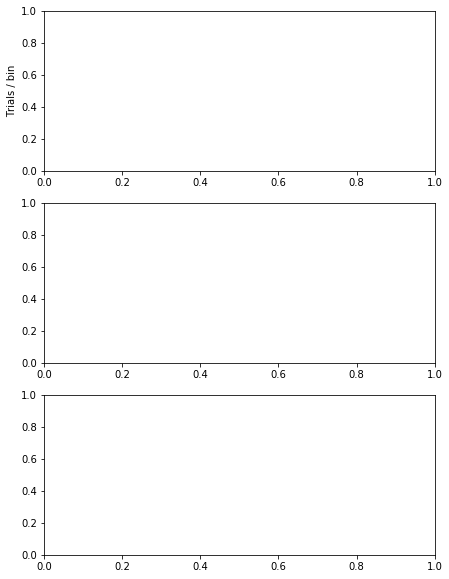

In [30]:
f, axes = plt.subplots(3, 1, figsize=(7, 10))

def hist_plot(data, bins, color, label):
    data = data[np.isfinite(data)]
    mean = np.mean(data)
    # Error calculation is very dodgy, since dist
    # is far from Gaussian.
    err = np.std(data)/len(data)**0.5

    Hist1d(data, bins=bins).plot(
        color=color, 
        set_xlim=True,
        errors=True,
        error_style='band',
        label=f'{label}: {mean:.2f} $\pm$ {err:.2f}')
    plt.axvline(mean,
                color=color,
                linestyle='--')
    plt.legend(loc='best', frameon=False)

def norm_plot(data, bins, color='k', label=r'$\mathcal{N}(\mu,\sigma)$', alpha=0.6):
    bin_centers = (bins[:-1] + bins[1:])/2
    plt.plot(bin_centers,
             n_trials*np.diff(stats.norm.cdf(bins,
                                             loc=np.nanmean(data),
                                             scale=np.nanstd(data))),
             color=color, alpha=alpha, label=label)

n_bins = 50
pvals = False
x_max = 70 if discovery else 5
x_min = 0 if discovery else -0.2

done=False

for ltype in likelihood_types:
    for nrc in nr_conditions: 
        if nrc == 'nr' and ltype == 'full': continue
        if (ltype, nrc) not in rocs:
            continue

        color = roc_colors[(ltype, nrc)]
        label = roc_labels[(ltype, nrc)]
        if label.startswith('Fd'):
            label = 'Flamedisx'
                
        q = sensi_results[ltype][nrc]

        ####################################################################################
        plt.sca(axes[0])
        bins = np.linspace(0, x_max, n_bins)
        hist_plot(q['bestfit_nr'],
                  bins=bins,
                  label=label, color=color)
        plt.xlabel("Best fit [DM events]")
        if discovery:
            plt.ylim(0, n_trials/11)
            norm_plot(q['bestfit_nr'], bins)
        else:
            plt.yscale('log')
            plt.ylim(0.7, n_trials)

        #####################################################################################
        plt.sca(axes[1])
        bins = np.linspace(x_min, x_max, n_bins)
        hist_plot(q['t'],
                  bins=bins,
                  label=label, color=color)
        plt.xlabel(r'$-2\ln\lambda(0)$') if discovery else plt.xlabel(r'$-2\ln\lambda(\mu)$')

        # plot asymptotic dist
        if discovery:
            plt.ylim(0, n_trials/14)
            bin_centers = (bins[:-1] + bins[1:])/2
     
            p_vals = stats.chi2(1).sf(q['t'])/2
            #sigmas = -stats.norm.ppf(p_vals)
            # Alternatively Z = sqrt(q0)
            sigmas = q['t']**0.5
            
            # plot noncentral chi2
            # BOTH of these should work
            #non_centrality = (0 - np.mean(q['bestfit_nr']))**2 / np.std(q['bestfit_nr'])**2
            non_centrality = np.median(q['t'])  # from Asimov likelihood

            plt.plot(bin_centers,
                     n_trials*np.diff(stats.ncx2.cdf(x=bins, df=1, nc=non_centrality)),
                    'k', alpha=0.6, label=r'$\chi^{2}(k=1, \lambda=$' + 'median' + r'$[q_{0}])$')

            # from Walk approx (checked this is equal to stats.ncx2 with non centr mu and sigma)
            #def f(q0, mu, sigma):
            #    # + (1 - Phi(mu/sigma))delta(q0)
            #    return np.exp(-1*(q0**0.5 - (mu/sigma))**2/2) / (2 * (2*np.pi)**0.5 * q0**0.5)

            #plt.plot(bin_centers,
            #         n_trials * (50.2/n_bins) * f(bin_centers, np.mean(q['bestfit_nr']), np.std(q['bestfit_nr'])),
            #         'r')
        else:
            plt.yscale('log')
            plt.ylim(0.7, n_trials)

            bins = np.linspace(x_min, x_max, n_bins)
            bin_centers = (bins[:-1] + bins[1:])/2
            #plt.plot(bin_centers, n_trials*0.5*np.diff(stats.chi2(1).cdf(bins)), 'k',
            #         label=r'$\frac{1}{2}\chi^{2}(k=1)$')
            # high res chi2
            test_ax = np.linspace(x_min, x_max, 200)
            plt.plot(test_ax, n_trials*0.5*stats.chi2(1).pdf(test_ax)*(bins[1]-bins[0]), 'k',
                     label=r'$\frac{1}{2}\chi^{2}(k=1)$')

        ##########################################################################################
        plt.sca(axes[2])
        if discovery:
            if pvals:
                bins = np.geomspace(1e-7, 1, n_bins)
                hist_plot(p_vals,
                          bins=bins,
                          label=label, color=color)
                plt.xscale('log')
                plt.xlabel('Discovery p-value')
            else:
                bins = np.linspace(0, 8, n_bins)
                hist_plot(sigmas,
                          bins=bins,
                          label=label, color=color)
                plt.xlabel('Discovery sigma')
                
                norm_plot(sigmas, bins)            
            plt.ylim(0, None)
        else:
            bins = np.geomspace(0.5, 100, n_bins)
            hist_plot(q['limit'], 
                      bins=bins,
                      label=label, color=color)
            plt.xlabel("Limit [DM events]")
            plt.xscale('log')
            plt.ylim(0, max(10, n_trials / 11))
            plt.xlim(0.5, 100)
            
            if not done:
                done=True
                
                def n_to_x(n):
                    return n * 1e-45 / nwimps
                def x_to_n(x):
                    return x * nwimps / 1e-45
                # xsec scale? compute expected n wimps, scale to where 1 wimp is 1e-45
                #nwimps
                secax = plt.gca().secondary_xaxis('top', functions=(n_to_x, x_to_n))
                #secax = plt.gca().twiny()
                secax.set_xlabel(r'Limit [cm$^2$]')
                #secax.set_xscale('log')
                #secax.set_xlim(0.5, 100)

                #new_tick_vals = np.geomspace(1e-48, 1e-47, 2) #secax.get_xticks()
                #tick_vals = new_tick_vals * nwimps / 1e-45
                #print(tick_vals)
                
                #secax.set_xticks(tick_vals)
                #secax.set_xticklabels(['%.2g' % (t*1e-45/nwimps) for t in tick_vals])
                #secax.set_xticklabels(['%.2g' % t for t in new_tick_vals])

for i_ax, ax in enumerate(axes):
    ax.set_ylabel("Trials / bin")

    if discovery or i_ax == 1: 
        plt.sca(ax)
        # Sort legend entries
        # https://stackoverflow.com/a/46160465
        handles, labels = ax.get_legend_handles_labels()
        order = [0,2,1]
        plt.legend([handles[idx] for idx in order],
                   [labels[idx] for idx in order],
                   frameon=False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
#plt.savefig('discovery_5ty_200GeV_10k.png', dpi=200, bbox_to_inches='tight')
#plt.savefig('sensitivity_15ty_200GeV_10k.png', dpi=200, bbox_to_inches='tight')


#plt.savefig('sensitivity_results_10ty_30wimps_200GeV_20200217_disc.png', dpi=200, bbox_inches='tight')
# Bottom panel for the paper
#extent = axes[2].get_window_extent().transformed(f.dpi_scale_trans.inverted())
#f.savefig('discovery_power.png', dpi=200, bbox_inches=extent.expanded(1.2, 1.4))

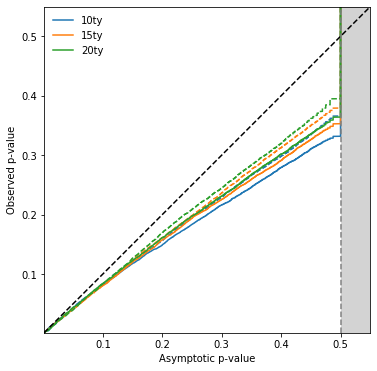

In [31]:
a = np.linspace(0, 1, 10_000)

log=False
mw = 200
exposures = [10, 15, 20]  # tonne year

plt.figure(figsize=(6,6))
for i, exp in enumerate(exposures):
    name = f'sensi_results_20200219_10k_{exp}ty_{mw}GeV.pkl'
    #name = 'sensi_results_20200225_1k_15ty_200GeV_xtol-6_gtol-5.pkl'
    with open(name, mode='rb') as f:
        sensi_res = pickle.load(f)
    r = sensi_res['full']['nr_mod']['t']
    r_mh = sensi_res['mh']['nr']['t']

    plt.plot(1 - (0.5 + 0.5*stats.chi2(1).cdf(np.sort(r).clip(0, None))),
             1-a,
             color=f'C{i}', label=f'{exp}ty')
    plt.plot(1 - (0.5 + 0.5*stats.chi2(1).cdf(np.sort(r_mh).clip(0, None))),
             1-a,
             color=f'C{i}', linestyle='--')  # label=f'{exp}ty')
plt.legend(frameon=False)
min_p = 1e-3
max_p = 1 if log else 0.55
plt.plot([min_p, max_p], [min_p, max_p], 'k--')
plt.axvline(0.5, color='gray', linestyle='--')
plt.fill_between([0.5, 1], 2*[1], 2*[min_p], color='lightgray', lw=0)
plt.gca().set_aspect(1)
if log:
    plt.yscale('log')
    plt.xscale('log')
plt.ylim(min_p, max_p)
plt.xlim(min_p, max_p)
plt.xlabel('Asymptotic p-value')
plt.ylabel('Observed p-value')
#plt.savefig('pvalue_check_200GeV_10k_linlin.png', dpi=200, bbox_to_inches='tight')
plt.show()